In [1]:
%matplotlib inline

In [2]:
from itertools import product
import os.path

import matplotlib.pyplot as plt
from matplotlib import ticker
import nengo
import nengo_spa as spa
import numpy as np
import seaborn as sns

In [3]:
def remove_passthrough(model):
    objs = model.all_ensembles + model.all_nodes
    conns = model.all_connections
    objs, conns = nengo.utils.builder.remove_passthrough_nodes(objs, conns)    

    model2 = nengo.Network(seed=2)
    for obj in objs:
        if isinstance(obj, nengo.Ensemble):
            model2.ensembles.append(obj)
        elif isinstance(obj, nengo.Node):
            model2.nodes.append(obj)
    for conn in conns:
        model2.connections.append(conn)  
    return model2

In [4]:
def get_connectivity(algebra, d=64, subdimensions=16):
    vocab = spa.Vocabulary(d, algebra=algebra)
    with spa.Network(seed=2) as model:
            model.config[spa.State].subdimensions = subdimensions
            pre1 = spa.State(vocab, neurons_per_dimension=5, represent_cc_identity=False)
            pre2 = spa.State(vocab, neurons_per_dimension=5, represent_cc_identity=False)
            post = spa.Bind(vocab, neurons_per_dimension=5)
            pre1 >> post.input_left
            pre2 >> post.input_right

    model2 = remove_passthrough(model)

    with nengo.Simulator(model2, optimize=False) as sim:
        pass

    pre = set()
    post = set()
    weights = {}

    for c in model2.connections:
        pre.add(c.pre)
        post.add(c.post)
        assert (c.pre, c.post) not in weights
        weights[(c.pre, c.post)] = sim.data[c.post].scaled_encoders @ sim.data[c].weights

    pre = tuple(pre)
    post = tuple(post)
    pre_neurons = [x.n_neurons for x in pre]
    post_neurons = [x.n_neurons for x in post]
    pre_total_neurons = np.concatenate(((0,), np.cumsum(pre_neurons)))
    post_total_neurons = np.concatenate(((0,), np.cumsum(post_neurons)))

    connectivity = np.zeros((pre_total_neurons[-1], post_total_neurons[-1]), dtype=bool)

    for i, j in product(range(len(pre)), range(len(post))):
        if (pre[i], post[j]) in weights:
            a = slice(pre_total_neurons[i], pre_total_neurons[i + 1])
            b = slice(post_total_neurons[j], post_total_neurons[j + 1])
            connectivity[a, b] = np.abs(weights[(pre[i], post[j])].T) > 0.
            
    return connectivity

In [5]:
textwidth = 390.56151 / 72.27
row_height = textwidth / 1.5 / 1.6
single_fig_size = (textwidth / 1.5, row_height)


def save_tight_fig(fig, path, **kwargs):
    dirname = os.path.dirname(path)
    if not os.path.exists(dirname):
        os.makedirs(dirname)
    fig.savefig(path, bbox_inches='tight', pad_inches=0., **kwargs)


weight = 'light'
sns.set('paper', 'ticks', None, rc={
    'axes.labelweight': weight,
    'axes.linewidth': 0.6,
    'axes.titleweight': weight,
    'font.cursive': ['cmsy10'],
    'font.sans-serif': ['Lato'],
    'font.weight': weight,
    'lines.linewidth': 1.,
    'lines.markersize': 4,
    'mathtext.fontset': 'custom',
})

In [13]:
#cc_conn = get_connectivity(spa.algebras.HrrAlgebra(), d=1688, subdimensions=8)
#vtb_conn = get_connectivity(spa.algebras.VtbAlgebra(), d=225, subdimensions=15)
cc_conn = get_connectivity(spa.algebras.HrrAlgebra(), d=64, subdimensions=8)
vtb_conn = get_connectivity(spa.algebras.VtbAlgebra(), d=64, subdimensions=32)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


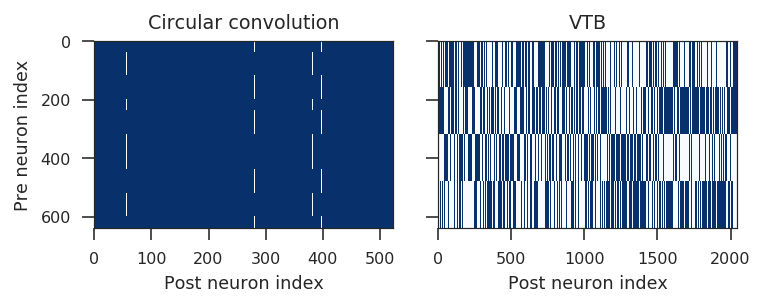

In [14]:
fig = plt.figure(figsize=(textwidth, row_height))

ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(cc_conn, aspect='auto', interpolation='none', vmin=0, vmax=1, cmap='Blues')

ax2 = fig.add_subplot(1, 2, 2, sharey=ax1)
ax2.label_outer()
im = ax2.imshow(vtb_conn, aspect='auto', interpolation='none', vmin=0, vmax=1, cmap='Blues')

ax1.set_xlabel("Post neuron index")
ax2.set_xlabel("Post neuron index")
ax1.set_ylabel("Pre neuron index")

ax1.set_title("Circular convolution")
ax2.set_title("VTB")

fig.tight_layout()

In [15]:
print(np.sum(cc_conn))
print(np.sum(vtb_conn))
print(np.sum(cc_conn) - np.sum(vtb_conn))

332800
655360
-322560


In [16]:
print(cc_conn.shape)
print(vtb_conn.shape)

(640, 524)
(640, 2048)


In [8]:
save_tight_fig(fig, '../../vtb-paper/figures/weights.pdf')